# (16.0) Описание решаемой задачи

В окружении выявленного айсберга необходимо осуществить поиск заявок, которые потенциально могут быть элементами цепочки всплытия айсберга, но при исполнении не были выявлены как айсберг, так как сделка была произведена ровно на объем видимой части

# (16.1) Установка всех необходимых пакетов¶

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# (16.2) Определение функций¶

In [34]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# восстановление стакана заявок и расчет основных метрик
def GlassBuild(for_lob):
    
    #формируем очередь заявок
    
    # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
    no_mkt_orders = for_lob['PRICE']!=0
    # таблица выставленных заявок
    plc_orders = for_lob[['ORDERNO','BUYSELL','PRICE','VOLUME']][(for_lob ['ACTION']==1) & no_mkt_orders]
    # таблица отмененных заявок
    wdr_orders = for_lob[['ORDERNO','VOLUME']][(for_lob ['ACTION'] == 0) & no_mkt_orders]
    # таблица исполненных заявок
    trd_orders = for_lob [['ORDERNO','VOLUME']][(for_lob['ACTION']==2) & no_mkt_orders]
    trd_orders = trd_orders.groupby(['ORDERNO']).sum()
    trd_orders['ORDERNO'] = trd_orders.index
    trd_orders.index=range(trd_orders.shape[0])
    # собираем все типы заявок в один датафрейм - очередь заявок
    lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
    lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
    lob_almost = lob_almost.fillna(0)
    lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
    # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
    lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]
    
    # строим стакан
    
    lob = lob_almost.pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
    lob.sort_index(axis = 0, inplace = True, ascending = False)
    lob = lob.fillna(0)
    
    # считаем метрики ликвидности
    
    # расчет лучшей цены на покупку
    bid_price = lob[lob['B'] > 0].index[0]
    # расчет объема на уровне лучшей цены на покупку
    bid_volume = lob['B'][bid_price]
    # расчет общего объема на стороне покупки
    bid_depth = lob['B'].sum()
    # расчет объема на уровне 10 лучших цен на стороне покупки
    b_10 = lob[lob['B'] > 0].index[0:10]
    volume_b_10 = 0
    for i in b_10:
        volume_b_10 = volume_b_10 + lob['B'][i]
    # расчет лучшей цены на продажу
    ask_price = lob[lob['S'] > 0].index[-1]
    # расчет объема на уровне лучшей цены на продажу
    ask_volume = lob['S'][ask_price]
    # расчет общего объема на стороне продажи
    ask_depth = lob['S'].sum()
    # расчет объема на уровне 10 лучших цен на стороне продажи
    s_10 = lob[lob['S'] > 0].index[-10:]
    volume_s_10 = 0
    for i in s_10:
        volume_s_10 = volume_s_10 + lob['S'][i]
    
    liquidity = [bid_price, bid_volume, bid_depth, volume_b_10, ask_price, ask_volume, ask_depth, volume_s_10]
     
    return(liquidity)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки перед айсбергом
def ChainPairPrev(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        prev_orderno = list_of_orderno[i+1]
        cur_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        cur_time_place = orders_instr.loc[cur_time_place_1,'TIME']
        prev_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == prev_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        prev_time_trd = orders_instr.loc[prev_time_trd_1,'TIME']
    
        if (cur_time_place >= prev_time_trd) and ((cur_time_place - prev_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, prev_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки после айсберга
def ChainPairSuc(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        suc_orderno = list_of_orderno[i+1]
        cur_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        cur_time_trd = orders_instr.loc[cur_time_trd_1,'TIME']
        suc_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == suc_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        suc_time_place = orders_instr.loc[suc_time_place_1,'TIME']
    
        if (suc_time_place >= cur_time_trd) and ((suc_time_place - cur_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, prev_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# (16.3) Список всех используемых датафреймов

In [4]:
# orders - ордерлог на заданную дату
# iceberg_all - список всех найденных айсбергов
# orders_instr - ордерлог по инструменту
# ice_instr - список айсбергов по одному инструменту за один день

# (16.4) Определение входных параметров

In [5]:
# создаем список из всех названий файлов с данными (из них в дальнейшем можно извлечь дату)
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [6]:
# создаем список из инструментов
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

In [112]:
d = orderlogs[0] 
date = int(d[8:16]) #20190304
ticker = tickers[0] #GAZP
delta = dt.timedelta(microseconds=90000)

# (16.5) Чтение данных

In [9]:
%%time
# преобразуем time в формат datetime
# orders - ордерлог за день
# instr_orders - ордерлог на заданную дату по выбранному инструменту на момет времени t
orders = pd.read_csv(d, header = 0)
orders['together_time'] = str(date)+orders['TIME'].apply(str)
orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
del orders['together_time']

CPU times: user 5min 33s, sys: 4.28 s, total: 5min 38s
Wall time: 5min 41s


In [10]:
orders_instr = orders[orders.SECCODE == ticker].reset_index()
orders_instr

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,53,54,GAZP,B,2019-03-04 10:00:00.000000,54,1,150.00,10,NaN,NaN
1,58,59,GAZP,B,2019-03-04 10:00:00.000000,59,1,151.59,200,NaN,NaN
2,65,66,GAZP,B,2019-03-04 10:00:00.000000,66,1,152.00,10,NaN,NaN
3,70,71,GAZP,B,2019-03-04 10:00:00.000000,71,1,154.99,10,NaN,NaN
4,431,432,GAZP,S,2019-03-04 10:00:00.000000,432,1,170.11,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
346742,5424218,5424219,GAZP,S,2019-03-04 18:44:29.740974,2198823,0,156.00,40,NaN,NaN
346743,5424219,5424220,GAZP,S,2019-03-04 18:44:32.098651,2326756,0,155.37,1000,NaN,NaN
346744,5424268,5424269,GAZP,S,2019-03-04 18:44:51.327893,2331971,0,155.50,10,NaN,NaN
346745,5424281,5424282,GAZP,S,2019-03-04 18:44:57.439758,2073027,0,157.45,1000,NaN,NaN


In [14]:
# читаем список выявленных айсберг-заявок + преобразуем время в формат datetime
# iceberg_all - список всех найденных айсбергов
# ice_instr - список айсбергов по одному инструменту за один день
iceberg_all = pd.read_csv('iceberg.csv', header = 0)
iceberg_all['together_time'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME'].apply(str)
iceberg_all['together_time_identified'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME_IDENT'].apply(str)
iceberg_all['TIME'] = [ReverseToDateTime(iceberg_all.together_time[i]) for i in range (len(iceberg_all.together_time))]
iceberg_all['TIME_IDENT'] = [ReverseToDateTime(iceberg_all.together_time_identified[i]) for i in range (len(iceberg_all.together_time_identified))]
iceberg_all['DELTA'] = iceberg_all['TIME_IDENT'] - iceberg_all['TIME']
del iceberg_all['together_time']
del iceberg_all['together_time_identified']

In [15]:
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]
ice_instr 

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
0,0,B,20190304,1,199077,156.28,GAZP,2019-03-04 10:06:43.595004,2019-03-04 10:09:36.467866,-2830,2000,00:02:52.872862
1,1,B,20190304,1,359638,156.18,GAZP,2019-03-04 10:30:27.072289,2019-03-04 10:53:31.759856,-210,2000,00:23:04.687567
2,2,S,20190304,1,397852,156.58,GAZP,2019-03-04 10:36:57.193855,2019-03-04 10:38:05.393784,-3000,2000,00:01:08.199929
3,3,B,20190304,1,486370,156.18,GAZP,2019-03-04 10:53:31.809856,2019-03-04 10:53:42.904115,-1000,1790,00:00:11.094259
4,4,B,20190304,1,516105,156.03,GAZP,2019-03-04 11:00:03.906212,2019-03-04 11:00:05.256841,-1000,2000,00:00:01.350629
...,...,...,...,...,...,...,...,...,...,...,...,...
169,169,S,20190304,1,2471641,154.99,GAZP,2019-03-04 18:17:19.044983,2019-03-04 18:17:20.153960,-1740,620,00:00:01.108977
170,170,S,20190304,1,2581833,154.65,GAZP,2019-03-04 18:39:44.074091,2019-03-04 18:39:44.074091,-1970,3000,00:00:00
171,171,S,20190304,1,2581834,154.65,GAZP,2019-03-04 18:39:44.074091,2019-03-04 18:39:44.074091,-1000,1030,00:00:00
172,172,S,20190304,1,2581835,154.65,GAZP,2019-03-04 18:39:44.074091,2019-03-04 18:39:44.074091,-830,2000,00:00:00


# (16.6) Выбираем айсберг для анализа

In [43]:
# вводим индекс айсберга из списка его окружения и извлекаем основную информацию из него
id = 164
test = ice_instr.loc[id]
buysell = ice_instr.loc[id][1]
date = ice_instr.loc[id][2]
orderno = ice_instr.loc[id][4]
price = ice_instr.loc[id][5]
ticker = ice_instr.loc[id][6]
time_place = ice_instr.loc[id][7]
time_ident = ice_instr.loc[id][8]
volume_ini = ice_instr.loc[id][10]

test

index                                164
BUYSELL                                B
DATE                            20190304
ICEBERG                                1
ORDERNO                          2391577
PRICE                                155
SECCODE                             GAZP
TIME          2019-03-04 18:02:41.726467
TIME_IDENT    2019-03-04 18:02:41.756361
VOLUME                             -1190
VOLUME_INI                          1000
DELTA             0 days 00:00:00.029894
Name: 164, dtype: object

# (16.7) Анализ интервала перед выставлением айсберга для поиска потенциальных элементов микроцепочки

In [378]:
# описание айсберга, который был выбран для анализа
ice_instr.loc[id]

index                                 83
BUYSELL                                S
DATE                            20190304
ICEBERG                                1
ORDERNO                          1791777
PRICE                             155.09
SECCODE                             GAZP
TIME          2019-03-04 15:43:06.296113
TIME_IDENT    2019-03-04 15:43:06.296485
VOLUME                              -640
VOLUME_INI                          1000
DELTA             0 days 00:00:00.000372
Name: 83, dtype: object

Предполагается, что найденный айсберг - это элемент цепочки всплытия айсберга и перед ним была исполнена как минимум одна заявка на объем видимой части, которая и инициировала всплытие айсберга. Поиск таких заявок необходимо осуществлять поиск заявок, удовлетворяющих следующим условиям:
1. orders_instr.ORDERNO < orderno  
2. orders_instr.PRICE == price
3. orders_instr.BUYSELL == buysell
4. время выставления следующей заявки находится в допустимом интервале после исполнения предыдущей
5. объем выставленной заявки == объему исполнения (НО! надо найти заявку с ACTION = 1 для этого)

In [113]:
%%time

ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
cur_price = orders_instr.loc[ice_index,'PRICE']

'''for i in range(ice_index):
        
        cur_index = ice_index - i
        for_lob = orders_instr[orders_instr.index <= cur_index]

        if buysell == 'B':
            
            if GlassBuild(for_lob)[0] < cur_price:

                left_border = orders_instr.loc[cur_index,'TIME']
                left_index = cur_index
                
                break

        elif buysell == 'S':
            
            if GlassBuild(for_lob)[4] > cur_price:
                
                left_border = orders_instr.loc[cur_index,'TIME']
                left_index = cur_index
                 
                break
print(left_border)'''

'''if left_border >= (time_place - delta):
    
    left_border = (time_place - delta)'''

left_border = ReverseToDateTime('20190304100000000000')

# отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
# test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
test = orders_instr[((orders_instr.BUYSELL == buysell) & 
             (orders_instr.PRICE == price) & 
             (orders_instr.TIME >= left_border)& 
             (orders_instr.TIME <= time_ident)&
             (orders_instr.ORDERNO < orderno)&
             (orders_instr.ACTION == 2)     
            )]['ORDERNO'].unique().tolist()

# проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
# test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
test1 = []

for i in test:
    
    trade_orderno = i
    order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
    
    if order_volume == volume_ini:
        
        test1.append(i)

# дописываем номер айсберг заявки в найденную цепочку
test1.append(orderno)
# разворачиваем список заявок от самой новой до самой старой
test1 = test1[::-1]

# проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
chain_prev = ChainPairPrev(test1)
chain_prev

CPU times: user 1.77 s, sys: 72.1 ms, total: 1.84 s
Wall time: 2.01 s


[2391577, 2391518, 2391493, 2391466, 2391462, 2391433, 2391423, 2391293]

In [45]:
orders_instr[orders_instr['ORDERNO'].isin (chain_prev)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315172,4952800,4952801,GAZP,B,2019-03-04 18:02:40.779646,2391293,1,155.0,1000,NaN,NaN
315173,4952801,4952802,GAZP,B,2019-03-04 18:02:40.779646,2391293,2,155.0,360,2.936006e+09,155.0
315176,4952810,4952811,GAZP,B,2019-03-04 18:02:40.780238,2391293,2,155.0,280,2.936006e+09,155.0
315179,4952814,4952815,GAZP,B,2019-03-04 18:02:40.780979,2391293,2,155.0,80,2.936006e+09,155.0
315182,4952817,4952818,GAZP,B,2019-03-04 18:02:40.781547,2391293,2,155.0,200,2.936006e+09,155.0
315186,4952934,4952935,GAZP,B,2019-03-04 18:02:41.562406,2391293,2,155.0,1530,2.936006e+09,155.0
315211,4953109,4953110,GAZP,B,2019-03-04 18:02:41.620190,2391423,1,155.0,1000,NaN,NaN
315215,4953114,4953115,GAZP,B,2019-03-04 18:02:41.621290,2391423,2,155.0,600,2.936006e+09,155.0
315219,4953120,4953121,GAZP,B,2019-03-04 18:02:41.631653,2391423,2,155.0,1600,2.936006e+09,155.0
315227,4953128,4953129,GAZP,B,2019-03-04 18:02:41.632828,2391433,1,155.0,1000,NaN,NaN


In [32]:
'''%%time
# зацикливаем поиск связанных заявок

x3 = []

for i in range(len(ice_instr)):
    
    id = ice_instr.index[i]
    buysell = iceberg_all.loc[id][1]
    date = iceberg_all.loc[id][2]
    orderno = iceberg_all.loc[id][4]
    price = iceberg_all.loc[id][5]
    ticker = iceberg_all.loc[id][6]
    time_place = iceberg_all.loc[id][7]
    time_ident = iceberg_all.loc[id][8]
    volume_ini = iceberg_all.loc[id][10]
    
    ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
    cur_price = price
    
    for i in range(ice_index):

            cur_index = ice_index - i
            for_lob = orders_instr[orders_instr.index <= cur_index]

            if buysell == 'B':

                if GlassBuild(for_lob)[0] < cur_price:

                    left_border = orders_instr.loc[cur_index,'TIME']
                    left_index = cur_index

                    break

            elif buysell == 'S':

                if GlassBuild(for_lob)[4] > cur_price:

                    left_border = orders_instr.loc[cur_index,'TIME']
                    left_index = cur_index

                    break
    print(1)
    
    if left_border >= (time_place - delta):

        left_border = (time_place - delta)
    
    left_border = (time_place - delta)

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    test = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= left_border)& 
                 (orders_instr.TIME <= time_ident)&
                 (orders_instr.ORDERNO < orderno)&
                 (orders_instr.ACTION == 2)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
    # test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    test1 = []

    for i in test:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

        if order_volume == volume_ini:

            test1.append(i)
    print(i)
    
    # дописываем номер айсберг заявки в найденную цепочку
    test1.append(orderno)
    # разворачиваем список заявок
    test1 = test1[::-1]
    # проверяем, что все отобранные заявки могут быть объединены в цепочку, для этого определяем, что в каждой паре
    # из двух следующих друг за другом заявок время выставления каждой следующей меньше времени исполнения предыдущей
    # если один из элементов цепочки не удовлетворяет этому условию, исключаем эту пару из цепочки и повторяем проверку
    chain = []

    while len(test1) != (len(chain)+1):

        chain = ChainPair(test1)
        test1 = []

        for i in chain:

            test1.append(i[0])

        test1.append(chain[len(chain)-1][1])
    print(i)
    
    print(i, len(test1))
    x3.append([test1])'''

83384
83384
83384 1
356176
356176
356176 1
2
2
2 1
468036
468036
468036 1
514050
[516105, 283520]
[516105, 283520] 2
5
5
5 1
560068
560068
560068 1
636970
[636970, 636648]
[636970, 636648] 3
8
8
8 1
9
9
9 1
707548
707548
707548 1
673151
673151
673151 1
871220
871220
871220 1
878888
878888
878888 1
881498
881498
881498 1
886166
886166
886166 1
914062
[914063, 914062]
[914063, 914062] 2
914063
[914063, 914062]
[914063, 914062] 3
914064
914064
914064 1
914065
914065
914065 1
914066
914066
914066 1
914067
914067
914067 1
914068
914068
914068 1
23
23
23 1
1026229
1026229
1026229 1
1059374
[1060698, 1052785]
[1060698, 1052785] 2
1084062
1084062
1084062 1
27
27
27 1
1104411
1104411
1104411 1
1104413
1104413
1104413 1
30
30
30 1
31
31
31 1
1104470
1104470
1104470 1
1110461
[1110466, 1110461]
[1110466, 1110461] 2
1110466
1110466
1110466 1
1110468
[1110474, 1110468]
[1110474, 1110468] 2
1110474
1110474
1110474 1
1114179


IndexError: list index out of range

# (16.5) Анализ интервала после вскрытия айсберга для поиска потенциальных элементов микроцепочки



In [114]:
right_border = ReverseToDateTime('20190304184500000000')

# отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
# train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
train = orders_instr[((orders_instr.BUYSELL == buysell) & 
             (orders_instr.PRICE == price) & 
             (orders_instr.TIME >= time_ident)& 
             (orders_instr.TIME <= right_border)&
             (orders_instr.ORDERNO > orderno)&
             (orders_instr.ACTION == 1)     
            )]['ORDERNO'].unique().tolist()

# проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
# train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
train1 = [orderno]

for i in train:
    
    trade_orderno = i
    order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
    
    if order_volume == volume_ini:
        
        train1.append(i)

# проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
chain_suc = ChainPairSuc(train1)
chain_suc

[2391577]

In [115]:
orders_instr[orders_instr['ORDERNO'].isin (chain_suc)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315288,4953515,4953516,GAZP,B,2019-03-04 18:02:41.726467,2391577,1,155.0,1000,NaN,NaN
315295,4953583,4953584,GAZP,B,2019-03-04 18:02:41.754006,2391577,2,155.0,590,2.936006e+09,155.0
315298,4953598,4953599,GAZP,B,2019-03-04 18:02:41.756361,2391577,2,155.0,1600,2.936006e+09,155.0


In [ ]:
'''%%time
# зацикливаем поиск связанных заявок
'''

# (16.6) Объединяем цепочки

Объединяем цепочку до с цепочкой после. Заносим информацию по цепочке (ордерно первого элемента chain) в ice_instr.chain_id  всех найденных айсбергов 
Добавить в цикл условие, что анализ цепочек проводится только для тех айсбергов, у которых пустой ice_instr.chain_id

In [116]:
# объединяем цепочку до с цепочкой после
chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]
chain

[2391293, 2391423, 2391433, 2391462, 2391466, 2391493, 2391518, 2391577]

In [117]:
orders_instr[orders_instr['ORDERNO'].isin (chain)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315172,4952800,4952801,GAZP,B,2019-03-04 18:02:40.779646,2391293,1,155.0,1000,NaN,NaN
315173,4952801,4952802,GAZP,B,2019-03-04 18:02:40.779646,2391293,2,155.0,360,2.936006e+09,155.0
315176,4952810,4952811,GAZP,B,2019-03-04 18:02:40.780238,2391293,2,155.0,280,2.936006e+09,155.0
315179,4952814,4952815,GAZP,B,2019-03-04 18:02:40.780979,2391293,2,155.0,80,2.936006e+09,155.0
315182,4952817,4952818,GAZP,B,2019-03-04 18:02:40.781547,2391293,2,155.0,200,2.936006e+09,155.0
315186,4952934,4952935,GAZP,B,2019-03-04 18:02:41.562406,2391293,2,155.0,1530,2.936006e+09,155.0
315211,4953109,4953110,GAZP,B,2019-03-04 18:02:41.620190,2391423,1,155.0,1000,NaN,NaN
315215,4953114,4953115,GAZP,B,2019-03-04 18:02:41.621290,2391423,2,155.0,600,2.936006e+09,155.0
315219,4953120,4953121,GAZP,B,2019-03-04 18:02:41.631653,2391423,2,155.0,1600,2.936006e+09,155.0
315227,4953128,4953129,GAZP,B,2019-03-04 18:02:41.632828,2391433,1,155.0,1000,NaN,NaN


In [118]:
# определяем индекс всех айсбергов, которые вошли в цепочку и меняем их chain_id
ices = ice_instr.index[ice_instr['ORDERNO'].isin(chain)].to_list()

for i in ices:
    
    ice_instr.loc[i, 'CHAIN_ID'] = chain[0]

In [122]:
ice_instr[ice_instr['ORDERNO'].isin (chain)]

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA,CHAIN_ID
157,157,B,20190304,1,2391293,155.0,GAZP,2019-03-04 18:02:40.779646,2019-03-04 18:02:41.562406,-1450,1000,00:00:00.782760,2391293
160,160,B,20190304,1,2391423,155.0,GAZP,2019-03-04 18:02:41.620190,2019-03-04 18:02:41.631653,-1200,1000,00:00:00.011463,2391293
161,161,B,20190304,1,2391466,155.0,GAZP,2019-03-04 18:02:41.670616,2019-03-04 18:02:41.677424,-1070,1000,00:00:00.006808,2391293
162,162,B,20190304,1,2391493,155.0,GAZP,2019-03-04 18:02:41.690554,2019-03-04 18:02:41.690691,-390,1000,00:00:00.000137,2391293
164,164,B,20190304,1,2391577,155.0,GAZP,2019-03-04 18:02:41.726467,2019-03-04 18:02:41.756361,-1190,1000,00:00:00.029894,2391293


# (16.7) Создаем цикл, в котором для разных дельт будет считаться длина цепочек одного и того же айсберга

In [135]:
sum = 1000
delta_list = [sum]

while sum <= 999000:
    
    sum = sum + 1000
    delta_list.append(sum)
    
delta_list

[1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 36000,
 37000,
 38000,
 39000,
 40000,
 41000,
 42000,
 43000,
 44000,
 45000,
 46000,
 47000,
 48000,
 49000,
 50000,
 51000,
 52000,
 53000,
 54000,
 55000,
 56000,
 57000,
 58000,
 59000,
 60000,
 61000,
 62000,
 63000,
 64000,
 65000,
 66000,
 67000,
 68000,
 69000,
 70000,
 71000,
 72000,
 73000,
 74000,
 75000,
 76000,
 77000,
 78000,
 79000,
 80000,
 81000,
 82000,
 83000,
 84000,
 85000,
 86000,
 87000,
 88000,
 89000,
 90000,
 91000,
 92000,
 93000,
 94000,
 95000,
 96000,
 97000,
 98000,
 99000,
 100000,
 101000,
 102000,
 103000,
 104000,
 105000,
 106000,
 107000,
 108000,
 109000,
 110000,
 111000,
 112000,
 113000,
 114000,
 115000,
 116000,
 117000,
 118000,
 119000,
 120000,
 121000,
 122000,
 123000,
 

In [142]:
%%time
results = []

for j in delta_list:
    
    delta = dt.timedelta(microseconds=j)

    ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
    cur_price = orders_instr.loc[ice_index,'PRICE']


    left_border = ReverseToDateTime('20190304100000000000')

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    test = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= left_border)& 
                 (orders_instr.TIME <= time_ident)&
                 (orders_instr.ORDERNO < orderno)&
                 (orders_instr.ACTION == 2)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
    # test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    test1 = []

    for i in test:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

        if order_volume == volume_ini:

            test1.append(i)

    # дописываем номер айсберг заявки в найденную цепочку
    test1.append(orderno)
    # разворачиваем список заявок от самой новой до самой старой
    test1 = test1[::-1]

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_prev = ChainPairPrev(test1)
    
    right_border = ReverseToDateTime('20190304184500000000')

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    train = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= time_ident)& 
                 (orders_instr.TIME <= right_border)&
                 (orders_instr.ORDERNO > orderno)&
                 (orders_instr.ACTION == 1)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
    # train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    train1 = [orderno]

    for i in train:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

        if order_volume == volume_ini:

            train1.append(i)

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_suc = ChainPairSuc(train1)
    
    chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]
    
    results.append([j, len(chain)])

NameError: name 'prev_orderno' is not defined

In [145]:
results

[[1000, 1],
 [2000, 2],
 [3000, 2],
 [4000, 2],
 [5000, 2],
 [6000, 2],
 [7000, 2],
 [8000, 2],
 [9000, 3],
 [10000, 3],
 [11000, 3],
 [12000, 3],
 [13000, 3],
 [14000, 7],
 [15000, 7],
 [16000, 7],
 [17000, 7],
 [18000, 7],
 [19000, 7],
 [20000, 7],
 [21000, 7],
 [22000, 7],
 [23000, 7],
 [24000, 7],
 [25000, 7],
 [26000, 7],
 [27000, 7],
 [28000, 7],
 [29000, 7],
 [30000, 7],
 [31000, 7],
 [32000, 7],
 [33000, 7],
 [34000, 7],
 [35000, 7],
 [36000, 7],
 [37000, 7],
 [38000, 7],
 [39000, 7],
 [40000, 7],
 [41000, 7],
 [42000, 7],
 [43000, 7],
 [44000, 7],
 [45000, 7],
 [46000, 7],
 [47000, 7],
 [48000, 7],
 [49000, 7],
 [50000, 7],
 [51000, 7],
 [52000, 7],
 [53000, 7],
 [54000, 7],
 [55000, 7],
 [56000, 7],
 [57000, 7],
 [58000, 8],
 [59000, 8],
 [60000, 8],
 [61000, 8],
 [62000, 8],
 [63000, 8],
 [64000, 8],
 [65000, 8],
 [66000, 8],
 [67000, 8],
 [68000, 8],
 [69000, 8],
 [70000, 8],
 [71000, 8],
 [72000, 8],
 [73000, 8],
 [74000, 8],
 [75000, 8],
 [76000, 8],
 [77000, 8],
 [78000,

In [146]:
step = []
count = []

for i in range(len(results)):
    
    step.append(results[i][0])
    count.append(results[i][1])
    
df1 = pd.DataFrame({'step':pd.Series(step),
     'count': pd.Series(count)})

df1

,step,count
0,1000,1
1,2000,2
2,3000,2
3,4000,2
4,5000,2
...,...,...
93,94000,8
94,95000,8
95,96000,8
96,97000,8


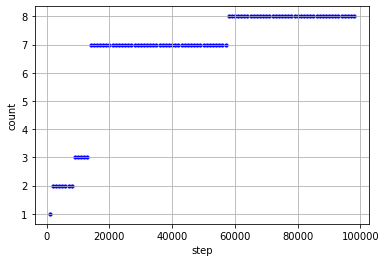

In [150]:
df1.plot.scatter(x='step', y='count', s=10, color='blue', grid=True)